In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, validation_curve
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('error')


In [99]:
filepath = os.path.join(os.getcwd(), '../data/final_experiment.csv')
df = pd.read_csv(filepath)
df['Class'] = df['Class'].apply(lambda val: 0 if val == 'Benign' else 1)
df = shuffle(df, random_state = 1)

In [100]:
df.shape

(36797, 35)

In [101]:
X = df.drop('Class', axis=1)
y = df.loc[:,'Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
random_state=1, stratify=y)

In [102]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (22078, 34)
X_test shape (14719, 34)
y_train shape (22078,)
y_test shape (14719,)


In [103]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
# Checking the range of parameters
degree = np.arange(1,5)
C = [32, 64,128, 256, 512, 1024]
train_accuracy = []
test_accuracy = []

for deg in degree:
    #Knn classifier with k neighbors
    clf = SVC(kernel='poly', degree=deg, random_state =1)
    #Fit the model
    clf.fit(X_train, y_train)
    #Compute accuracy on the training set and test set
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
  

In [105]:
train_loss = []
validation_loss = []

for score in train_accuracy:
    train_loss.append((1 - score))

for score in test_accuracy:
    validation_loss.append((1 - score))

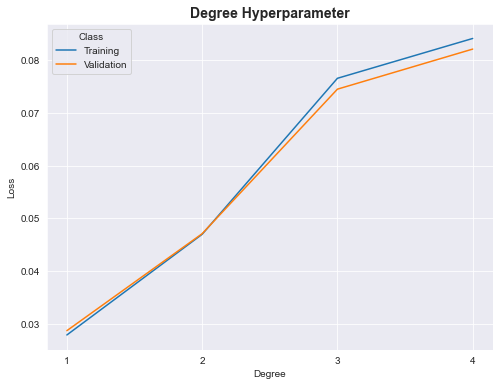

In [106]:
# # #Generate plot
x_ticks = np.arange(0, len(degree))
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6));
sns.lineplot(data=[train_loss, validation_loss], dashes=False, ax=ax)
ax.set_title('Degree Hyperparameter', fontsize=14, fontweight='bold');
ax.set(xlabel='Degree', ylabel='Loss');
ax.legend(title='Class', labels=['Training', 'Validation']);
plt.xticks(ticks=x_ticks, labels=degree);
# ax.set(xlim=(2,128));
plt.savefig('../tuning/exp3_svm_degrees.png', dpi=300)

In [ ]:
# # # tuning the hyperparameters

param_grid = {
    'kernel': ['poly'],
    'degree' : [1, 2, 3,],
    'C': [128,256, 512]
    
    }


grid = GridSearchCV(
    estimator = SVC(),
    param_grid= param_grid , 
    verbose =1, 
    cv=5, 
    return_train_score=True, 
)
grid.fit(X_train,y_train)

In [ ]:
print(f'Best paramater:  {grid.best_params_}')
print(f'Best score: {(grid.best_score_ * 100):.3f} %')

Best paramater:  {'C': 512, 'degree': 3, 'kernel': 'poly'}
Best score: 99.136 %


In [61]:
# # fitting the model
svm_ = SVC(kernel="poly", C=512, degree=3, random_state=10)

In [63]:
# evaluating the models

In [64]:
def sensitivity(conf):
 return conf[1][1] / (conf[1][1] + conf[1][0])

def specificity(conf):
 return conf[0][0] / (conf[0][0] + conf[0][1])


In [65]:
def evaluate_model(X, y):

    train_accuracy = []
    test_accuracy = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrix_scores = []
    precision_scores = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2) 
    for train, test in  cv.split(X,y):
        X_train_strat = X.iloc[train]
        y_train_strat = y.iloc[train]
        X_test_strat = X.iloc[test]
        y_test_strat = y.iloc[test]

        svm_.fit(X_train_strat, y_train_strat)

        
        y_pred_train_strat = svm_.predict(X_train_strat)
        y_pred_strat = svm_.predict(X_test_strat)
        
        train_accuracy.append(accuracy_score(y_train_strat, y_pred_train_strat))
        test_accuracy.append(accuracy_score(y_test_strat, y_pred_strat))
        

        conf = confusion_matrix(y_test_strat,y_pred_strat)

        confusion_matrix_scores.append(conf) 
        precision_scores.append(precision_score(y_test_strat,y_pred_strat))
        sensitivity_scores.append(sensitivity(conf))
        specificity_scores.append(specificity(conf))

    return (train_accuracy, test_accuracy, confusion_matrix_scores, 
            precision_scores,sensitivity_scores, 
            specificity_scores)


In [66]:
train_accuracy, test_accuracy, confusion_matrix_scores, precision_scores, sensitivity_scores,specificity_scores = evaluate_model(X, y)

In [69]:
def average(array):
    total = 0
    for score in array:
        total += score

    return (f'{(total / 5 * 100):.2f}')

def score(array):
    for score in array:
        print(f'{(score * 100):.2f}') 

In [70]:
score(train_accuracy)
average(train_accuracy)


92.28
92.42
92.90
92.23
92.61


'92.49'

In [71]:
score(test_accuracy)
average(test_accuracy)

92.38
91.73
93.08
92.47
92.63


'92.46'

In [72]:
for cf in confusion_matrix_scores:
    print(cf , "\n")

[[3922   83]
 [ 478 2877]] 

[[3913   92]
 [ 517 2838]] 

[[3921   84]
 [ 425 2929]] 

[[3937   67]
 [ 487 2868]] 

[[3912   92]
 [ 450 2905]] 



In [73]:
# precision_scores
score(precision_scores)
average(precision_scores)

97.20
96.86
97.21
97.72
96.93


'97.18'

In [74]:
score(sensitivity_scores)
average(sensitivity_scores)

85.75
84.59
87.33
85.48
86.59


'85.95'

In [75]:
# sensitivity_scores
score(specificity_scores)
average(specificity_scores)

97.93
97.70
97.90
98.33
97.70


'97.91'

In [ ]:
# specificity_scores


In [ ]:
# necessary for plotting validation curve

In [ ]:
# train_scores, valid_scores= validation_curve(
#     SVC(kernel="poly"),
#     X_train, y_train,
#     param_name="degree",
#     scoring="precision",
#     param_range=np.arange(1,10,2)
# )

In [ ]:
# train_loss = []
# validation_loss = []

# for score in train_scores.flatten():
#     train_loss.append(( 1 - score))

# for score in valid_scores.flatten():
#     validation_loss.append((1 - score))

In [ ]:
# sns.set_style(style="darkgrid")
# fig, ax = plt.subplots(figsize=(8,6));
# sns.lineplot(data=[train_loss, validation_loss], dashes=False, ax=ax)
# ax.set_title('Validation Curve for KNeighborsClassifier', fontsize=12, fontweight='bold');
# # ax.set_xlim([1,6])
# ax.set(xlabel='Number of neighbors', ylabel='Accuracy');
# ax.legend(title='', labels=['Training Loss', 'Validation Loss']);
# # plt.savefig('images/hyper_knn_exp3.png', dpi=300)